# C-MAPSS Aircraft Engine RUL Prediction

En los últimos años, dentro del campo de la Gestión de Activos Físicos, diversas investigaciones han propuesto la utilización de modelos de deep learning cada vez más sofisticados para la estimación y predicción del tiempo de vida remanente (RUL) de equipos y/o componentes particulares. El tiempo de vida remanente o Remaining Useful Life (RUL) consiste en una variable utilizada principalmente para describir la degradación temporal de un activo durante su operación y describe el tiempo de operación remanente del activo antes de que ocurra su falla. De este modo, mejores estimadores de esta variable resultan de suma importancia a la hora de gestionar e implementar mejores políticas de mantenimiento y operación.

  <img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_03/bin/scatter_rul.png" height="200"> <img src="https://www.researchgate.net/profile/Xiaolei_Fang/publication/310789705/figure/fig2/AS:462413100261377@1487259282977/Simplified-diagram-of-engine-simulated-in-C-MAPSS-6.png" height="200">

El Comercial Modular Aero-Propulsion System Simulation (C-MAPSS) es un software desarrollado por NASA como ambiente de simulación de motores de reacción tipo turbofán. Así, esta herramienta permite la implementación y evaluación de algoritmos de control y diagnóstico sobre la operación de un motor turbofán de 90.000 lbf de propulsión.

A diferencia de los workshops del curso, en esta tarea trabajarán con los datasets `CMAPSS_FD001_raw.npz` y `CMAPSS_FD004_raw.npz`. Estos datasets ya han sido procesados para extraer las ventanas de datos de cada una de las simulaciones. No obstante, los datos esta vez no se encuentran normalizados, por lo que procuren utilizar `MinMaxScaler` previo al entrenamiento de sus modelos.

    Dataset FD001
    - Condiciones Operacionales: 1
    - Modos de Falla: 1
    - Simulaciones de Entrenamiento: 100
    - Simulaciones de Testing: 100
    - Timesteps: 30
    - Sensors: 19

    Dataset FD004
    - Condiciones Operacionales: 6
    - Modos de Falla: 2
    - Simulaciones de Entrenamiento: 249
    - Simulaciones de Testing: 237
    - Timesteps: 30
    - Sensors: 19

Cada uno de los datasets cuenta con los conjuntos `X_train`, `Y_train`, `X_test` e `Y_test`, previamente definidos. Similar al dataset utilizado en los workshops, estos conjuntos presentan las ventanas de datos separadas por simulación. Recuerden utilizar `np.vstack` y `np.reshape` para reestructurar los arreglos a una forma compatible con las estructuras y capas de `keras`.

Para facilitar la carga de los archivos a un entorno de Google Colab, los archivos han sido cargados a un Google Drive. Copien el siguiente bloque de código en su Notebook para ejecutar la rutina de descarga. Los archivos serán cargados en el directorio `\content\datasets`.

In [1]:
!pip install -U -q PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# inicializar GoogleDrive con credenciales de autorización
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# crear carpeta para descargar los archivos .npz
!mkdir /content/datasets

# Google Drive IDs para descargar los archivos .npz
files_id = [('CMAPSS_FD001_raw.npz', '1ZcYauNQs_-QZMndP2THq6tQ53M6aWZJb'),
            ('CMAPSS_FD004_raw.npz', '1lbGpuYZFGjmcu-xiE1ehsqlhPC4S2cWN')]

# comenzar descarga
print('descargando datasets: ', end='')

for filename, id in files_id:
  save_path = os.path.join('/content/datasets', filename)

  # descargar y guardar en /content/datasets
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(save_path)

# indicar descarga terminada
print('done')

mkdir: cannot create directory ‘/content/datasets’: File exists
descargando datasets: done


In [2]:
import numpy as np

# cargar archivo npz
dataset = np.load('/content/datasets/CMAPSS_FD001_raw.npz', allow_pickle=True)

# sacar conjunto X_train
X_train = dataset['X_train']
Y_train = dataset['Y_train']
X_test = dataset['X_test']
Y_test = dataset['Y_test']

# print npz keys
print( list( dataset.keys() ) )

['X_train', 'Y_train', 'X_test', 'Y_test']


## Formato de Entrega

Los entregables de esta tarea son los siguientes.
- Jupyter Notebook (.ipynb): Todo el procesamiento de la tarea debe estar contenido en un único Notebook. Considere este archivo como un informe de metodología donde se reporten todos los pasos y bloques de código utilizados para resolver el problema. **Sea ordenado**; utilice comentarios en su código y bloques de texto para mejorar la legibilidad del Notebook.

- Reporte Resultados (.pdf): Este archivo debe contener los resultados obtenidos en su tarea, junto con un análisis correspondiente. Considere este documento como la sección de Resultados y Análisis de la tarea. En este sentido, debe mantener un formato de informe estándar.

### Utils desde github del curso

In [8]:
# ----------------------------------------------------------------------------
def plot_loss_function(train_info, figsize=(5,5)):
    """
    -> None
    
    this function plots de evolution of the loss function of the model 
    during the training epochs.
    
    :param train_info:
        training history of the classification model.
        
    """
    # crear figura
    plt.figure(figsize=figsize)
    
    plt.plot(train_info.history['loss'])
    plt.plot(train_info.history['val_loss'])
    
    # caracteristicas del plot
    plt.title('Model loss')
    plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
 
# ----------------------------------------------------------------------------

In [9]:
from matplotlib import cm
# ----------------------------------------------------------------------------    
def plot_predict_scatter(Y_true, Y_pred, eps=0.05, figsize=(12, 5), title='', **kargs):
    """
    -> None
    
    Plotea la disperción entre Y_true e Y_pred (este último correspondiente
    a la predicción realizada por el modelo) con el fin de visualizar el 
    desempeño del modelo.
    
    :param DataFrame Y_true:
        set de datos reales con los cuales comparar las estimaciones.
    :param DataFrame Y_pred:
        set de datos obtenidos con el modelo.
    :param float eps:
        radio que determina la vecindad de los puntos.
    :param str title:
        titulo a poner en el plot.
        
    :returns:
        None
    """
    
    # reordenar datos
    Y_true = np.array(Y_true).flatten()
    Y_pred = np.array(Y_pred).flatten()
    
    # calcular densidad
    z = np.zeros_like(Y_true)
    
    for i in range( Y_true.shape[0] ):
        # distancia
        dist = np.sqrt( (Y_true[i] - Y_true)**2 + (Y_pred[i] - Y_pred)**2 )
        # cantidad de vecinos
        z[i] = np.sum( dist < eps )
        
    # ordenar datos
    idx = np.argsort(z)
    Y_true, Y_pred, z = Y_true[idx], Y_pred[idx], z[idx]
    
    # obtener colores
    cmap = cm.get_cmap('jet')
    z_min, z_max = np.min(z), np.max(z)
    
    colors = cmap( (z - z_min)/(z_max - z_min) )
    
    # inicializar plot
    fig = plt.figure(figsize=figsize)
    
    # plotear Y_true vs Y_pred
    plt.scatter(Y_true, Y_pred, c=colors,**kargs)
    
    # plotear linea 1:1
    plt.plot([0, 300], [0, 300], c='k')
    
    # añadir limites
    plt.xlim([0, 300])
    plt.ylim([0, 300])
    
    #plt.title(title)
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.show()
    return None

# ----------------------------------------------------------------------------  

In [10]:

# ----------------------------------------------------------------------------    
def plot_RUL_scatter(Y_true, Y_pred, eps=0.05, figsize=(12, 5), title='', **kargs):
    """
    -> None
    
    Plotea la disperción entre Y_true e Y_pred (este último correspondiente
    a la predicción realizada por el modelo) con el fin de visualizar el 
    desempeño del modelo para estimar el RUL de la turbina.
    
    :param DataFrame Y_true:
        set de datos reales con los cuales comparar las estimaciones.
    :param DataFrame Y_pred:
        set de datos obtenidos con el modelo.
    :param float eps:
        radio que determina la vecindad de los puntos.
    :param str title:
        titulo a poner en el plot.
        
    :returns:
        None
    """
    
    # reordenar datos
    Y_true = np.array(Y_true).flatten()
    Y_pred = np.array(Y_pred).flatten()
    
    # calcular densidad
    z = np.zeros_like(Y_true)
    
    for i in range( Y_true.shape[0] ):
        # distancia
        dist = np.sqrt( (Y_true[i] - Y_true)**2 + (Y_pred[i] - Y_pred)**2 )
        # cantidad de vecinos
        z[i] = np.sum( dist < eps )
        
    # ordenar datos
    idx = np.argsort(z)
    Y_true, Y_pred, z = Y_true[idx], Y_pred[idx], z[idx]
    
    # obtener colores
    cmap = cm.get_cmap('jet')
    z_min, z_max = np.min(z), np.max(z)
    
    colors = cmap( (z - z_min)/(z_max - z_min) )
    
    # inicializar plot
    fig = plt.figure(figsize=figsize)
    
    # plotear Y_true vs Y_pred
    plt.scatter(Y_true, Y_pred, c=colors,**kargs)
    
    # obtener máximos y mínimos
    pred_min, pred_max = np.min(Y_pred), np.max(Y_pred)
    true_min, true_max = np.min(Y_true), np.max(Y_true)
    
    # plotear linea 1:1
    plt.plot([true_min, true_max], [pred_min, pred_max], c='k')
    
    # añadir limites
    plt.xlim([true_min, true_max])
    plt.ylim([pred_min, pred_max])
    
    #plt.title(title)
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.show()
    return None


In [11]:

# ----------------------------------------------------------------------------    
def plot_RUL_sorted(Y_true, Y_pred, figsize=(12, 5), title='', **kargs):
    """
    -> None
    
    Plotea una comparación ordenada entre Y_true e Y_pred (este último
    corresponditente a la predicción realizada por el modelo) con el fin de
    visualizar el desempeño del modelo para estimar el RUL de la turbina.
    
    Plotea la disperción entre Y_true e Y_pred (este último correspondiente
    a la predicción realizada por el modelo) con el fin de visualizar el 
    desempeño del modelo para estimar el RUL de la turbina.
    
    :param DataFrame Y_true:
        set de datos reales con los cuales comparar las estimaciones.
    :param DataFrame Y_pred:
        set de datos obtenidos con el modelo.
    :param str title:
        titulo a poner en el plot.
        
    :returns:
        None
    """
    
    # reordenar datos
    Y_true = np.array(Y_true).flatten()
    Y_pred = np.array(Y_pred).flatten()
    
    # sorting
    sort_idx = np.argsort(Y_true)
    Y_true = Y_true[sort_idx]
    Y_pred = Y_pred[sort_idx]
    
    # plot
    fig = plt.figure(figsize=figsize)
    
    plt.plot(Y_true, linestyle='-', linewidth=0.5, marker='o', markersize=3, label = 'True')
    plt.plot(Y_pred, linestyle='-', linewidth=0.5, marker='^', markersize=3, label = 'Prediction')
    
    #plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('RUL')
    plt.grid(True)
    plt.show()
    
    return None

## Exploración de los datos

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [12]:
def processData(dataset):

    # sacar conjunto X_train
    print('cargar datos')
    X_train = dataset['X_train']
    Y_train = dataset['Y_train']
    X_test = dataset['X_test']
    Y_test = dataset['Y_test']
    
    # se stackean las simulaciones de entrenamiento
    print('stackear datos')
    X_train_ = np.vstack(X_train)
    Y_train = np.vstack(Y_train)
    X_test_ = np.vstack(X_test)
    Y_test = np.vstack(Y_test)

    n_features = X_train_.shape[2]
    mantener = []

    print('sacar datos constantes')
    for col in range(n_features):
        try:
            std = np.std(X_train_[:,:,col].reshape(-1,1))
            if std > 1e-5:
                mantener.append(col)
        except:
            print('a sacar col ', col)

    mantener = np.array(mantener)
    print('se mantienen los siguientes features ', mantener)

    print(X_train_.shape)

    X_train_ = np.stack([x[:,mantener] for x in X_train_ ])
    X_test_ = np.stack([x[:,mantener] for x in X_test_ ])

    print(X_train_.shape)
    n_features = X_train_.shape[2]

    print('explorar distribuciones de datos de entrenamiento')
    fig, axs = plt.subplots(2, n_features, figsize=(28,4),
                            constrained_layout=True)

    fig.suptitle('sensors histogram', fontsize=24)
    for sensor in range(n_features):
        axs[0,sensor].hist(X_train_[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
        axs[0,sensor].set_title(sensor)
        axs[1,sensor].hist(X_test_[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
    
    plt.show()

    print('reescalando datos con minMaxScaler')

    X_train_ = X_train_.reshape(-1, n_features)
    X_test_ = X_test_.reshape(-1, n_features)
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    X_train = scaler.fit_transform(X_train_).reshape(-1,30, n_features)
    X_test = scaler.transform(X_test_).reshape(-1,30, n_features)

    print('plotear una simulacion train')
    n = 28
    fig, axs = plt.subplots(1,2,figsize=(20,5))

    axs[0].set_title('RUL {}'.format(Y_train[n]))
    axs[0].set_ylabel('sensors')
    axs[0].set_xlabel('timesteps')
    axs[0].plot(X_train[n])
    axs[1].set_title('RUL {}'.format(Y_test[n]))
    axs[1].set_ylabel('sensors')
    axs[1].set_xlabel('timesteps')
    axs[1].plot(X_test[n])
    plt.show()

    print('explorar distribuciones de datos de entrenamiento y test')
    fig, axs = plt.subplots(2, n_features, figsize=(28,4),
                            sharex='col', sharey='col',
                            constrained_layout=True)

    fig.suptitle('sensors histogram', fontsize=24)
    for sensor in range(n_features):
        axs[0,sensor].hist(X_train[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
        axs[0,sensor].set_title(sensor)
        axs[1,sensor].hist(X_test[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
    
    plt.show()

    """
    se crea un conjunto de test para contrastar los resultados sobre el conjunto
    de test entregado. Este conjunto nunca es visto por el modelo y se
    prueba el modelo sobre este
    """
    X_train, X_test2, Y_train, Y_test2 = train_test_split(X_train, Y_train,
                                                      test_size=0.2,
                                                      random_state=0)


    return X_train, Y_train, X_test, Y_test, X_test2, Y_test2

De este análisis de las distribuciones de los datos de entrenamiento (histogramas de fila superior del gráfico de sensor histogram) y test (histogramas fila inferior), se puede ver que ambos tienen el mismo contenido de información, por lo que si se entrena correctamente un método de regresión o clasificación en el dataset de entrenamiento, se debería tener un buen desempeño en el conjunto de test.


## 1. Recurrent Models FD001

Para el dataset `FD001` deben implementar y entrenar dos modelos de pronóstico de RUL, utilizando capas RNN y LSTM, respectivamente.

Recuerden que este problema de pronóstico consiste en un problema de regresión, por lo que como se vio en clases, deben utilizar el `mean squared error` como métrica de evaluación y función de pérdida.

Ajusten los hiperparámetros de sus modelos tipo RNN y LSTM para reducir el `mse` sobre un conjunto de validación `(X_val, Y_val)` que deberán generar a partir de las simulaciones de entrenamiento. Luego, para cada modelo reporten:

- RMSE sobre conjunto de testing y tiempo de entrenamiento para tres (3) iteraciones de entrenamiento, junto con sus promedios.

Discutan sobre las diferencias a nivel de desempeño y tiempo de entrenamiento que se observan entre ambos tipos de redes. Fundamenten en base a la estructura teórica de estas celdas recurrentes.

Comenten sobre si en este caso se justifica el uso de capas LSTM.

cargar datos
stackear datos
sacar datos constantes
se mantienen los siguientes features  [ 1  2  3  5  6  7  8  9 10 11 12 13 14 17 18]
(17731, 30, 19)
(17731, 30, 15)
explorar distribuciones de datos de entrenamiento


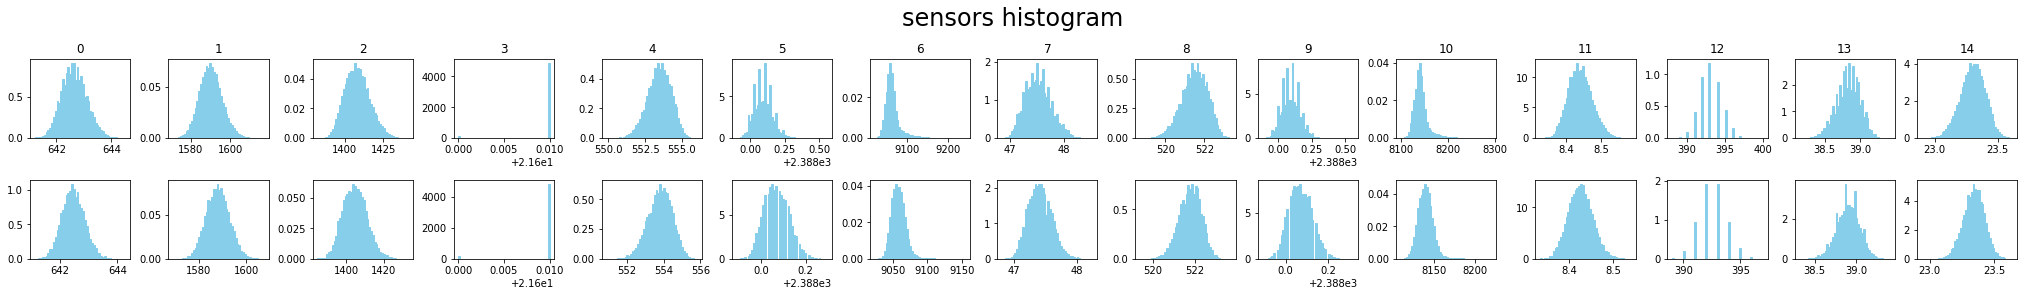

reescalando datos con minMaxScaler
plotear una simulacion train


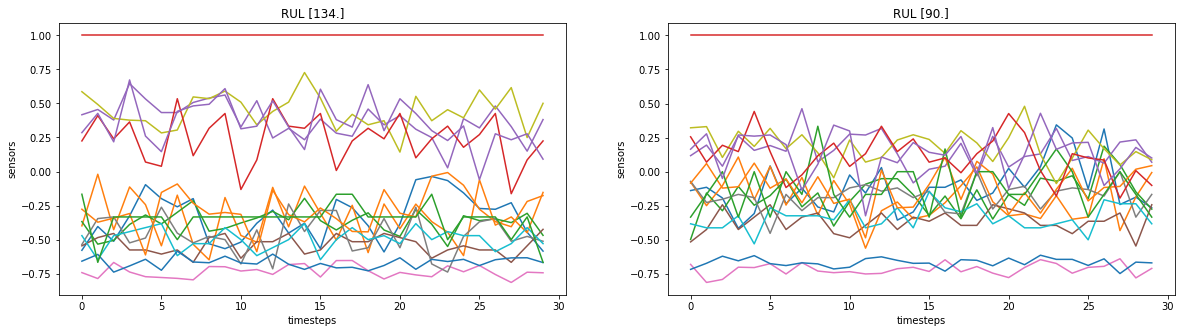

explorar distribuciones de datos de entrenamiento y test


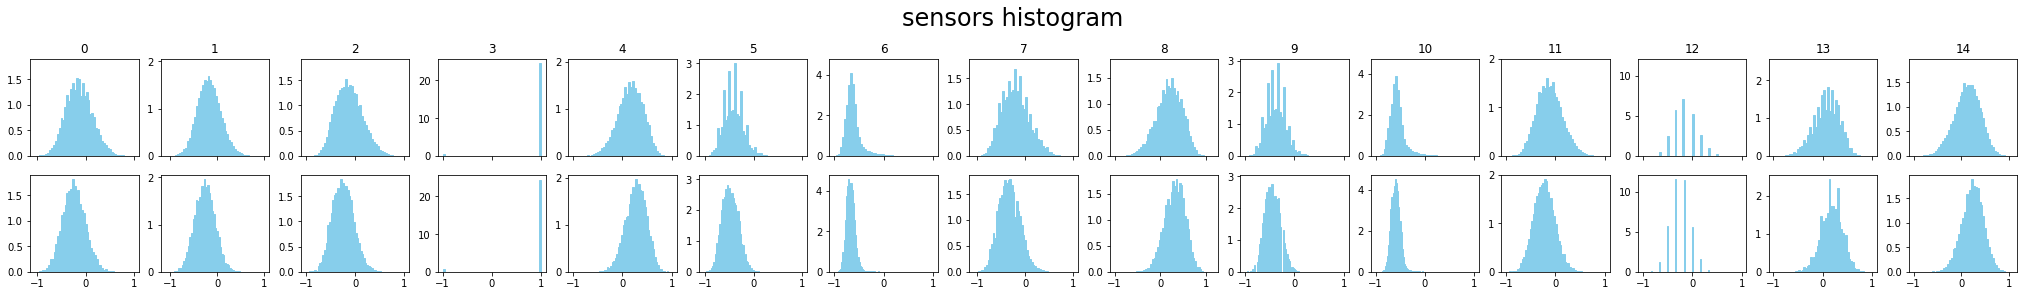

In [13]:
# cargar archivo npz
dataset = np.load('/content/datasets/CMAPSS_FD001_raw.npz', allow_pickle=True)

X_train, Y_train, X_test, Y_test, X_test2, Y_test2 = processData(dataset)

n_features = X_train.shape[2]


In [14]:
import keras
from keras.models import Sequential
from keras.layers import Input

from keras.layers import SimpleRNN as RNN
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

from keras import layers

from keras.optimizers import Adam


In [15]:
def train(model, X_train, Y_train, X_test, Y_test, X_test2, Y_test2, epochs):

    print('inicializacion de parametros')
    opt = Adam( learning_rate=1e-3 )

    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

    model.compile(loss='mse', optimizer=opt, metrics=['mae'])

    print('realizar data splitting')
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                      test_size=0.2,
                                                      random_state=0)

    # print sample distribution
    print( 'train split: {:d} samples'.format(X_train.shape[0]) )
    print( '\nvalidation split: {:d} samples'.format(X_val.shape[0]) )
    
    print('realizar rutina de entrenamiento')
    model_history = model.fit(X_train, Y_train,
                              batch_size=128, epochs=epochs,
                              validation_data=(X_val, Y_val),
                              callbacks=[callback])

    # plot gráfico de función de pérdida
    plot_loss_function(model_history, figsize=(10,4))
    
    Y_pred = model.predict( X_test2 )
    Y_true = Y_test2
    rmse = np.sqrt( np.mean( np.power( Y_pred - Y_true, 2 ), axis=None ) )
    print('test2 rmse: {:1.3f}'.format(rmse))
    plot_RUL_scatter(Y_true, Y_pred, eps=15)
    plot_RUL_sorted(Y_true, Y_pred, eps=15)

    # obtener predicciones de X_test del dataset
    Y_pred = model.predict( X_test )
    Y_true = Y_test
    rmse = np.sqrt( np.mean( np.power( Y_pred - Y_true, 2 ), axis=None ) )
    print('testing rmse: {:1.3f}'.format(rmse))
    plot_RUL_scatter(Y_true, Y_pred, eps=15)
    plot_RUL_sorted(Y_true, Y_pred, eps=15)

In [16]:
# RNN
def runRNN():
    # inicializar modelo keras.Sequential
    model = Sequential()

    input_dim = ( 30, n_features )
    model.add( Input( shape=input_dim ) )

    model.add( RNN(64, activation='relu', return_sequences=True ) )
    model.add( RNN(64, activation='relu', return_sequences=True ) )
    model.add( Dropout(rate=0.1) )
    model.add( RNN(32, activation='relu', return_sequences=True ) )
    model.add( RNN(32, activation='relu', return_sequences=True ) )

    model.add( Flatten() )
    model.add( Dropout(rate=0.2) )
    model.add( Dense(units=96, activation='relu') )
    model.add( Dense(units=96, activation='relu') )
    model.add( Dense(units=64, activation='relu') )
    model.add( Dense(units=64, activation='relu') )
    model.add( Dense(units=1, activation='linear') )

    train(model, X_train, Y_train, X_test, Y_test, X_test2, Y_test2, 100)

inicializacion de parametros
realizar data splitting
train split: 11347 samples

validation split: 2837 samples
realizar rutina de entrenamiento
Epoch 1/100
89/89 [==============================] - 5s 52ms/step - loss: 2730.7563 - mae: 37.9051 - val_loss: 1626.1660 - val_mae: 29.7103
Epoch 2/100
89/89 [==============================] - 4s 46ms/step - loss: 1625.3273 - mae: 29.0819 - val_loss: 1495.9878 - val_mae: 27.4864
Epoch 3/100
89/89 [==============================] - 4s 45ms/step - loss: 1449.0056 - mae: 27.0972 - val_loss: 1291.1887 - val_mae: 25.2964
Epoch 4/100
89/89 [==============================] - 4s 47ms/step - loss: 1304.4398 - mae: 25.4178 - val_loss: 1215.3043 - val_mae: 24.5619
Epoch 5/100
89/89 [==============================] - 4s 46ms/step - loss: 1265.1379 - mae: 25.1590 - val_loss: 1142.5103 - val_mae: 23.6690
Epoch 6/100
89/89 [==============================] - 4s 46ms/step - loss: 1111.0309 - mae: 23.5087 - val_loss: 1045.3540 - val_mae: 23.1275
Epoch 7/100
89/

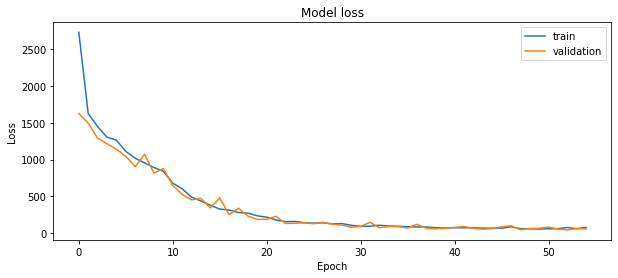

test2 rmse: 7.454


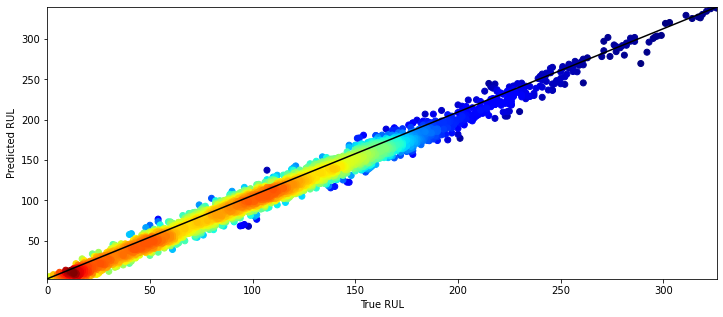

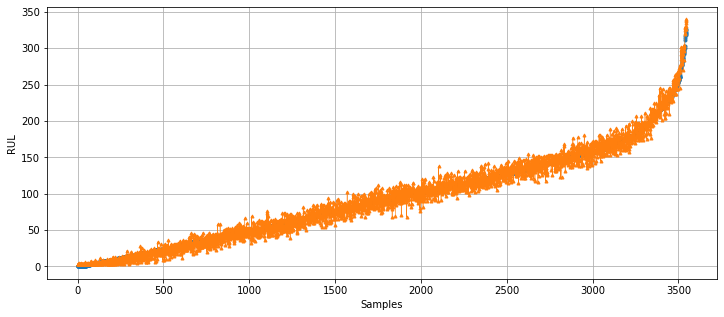

testing rmse: 78.061


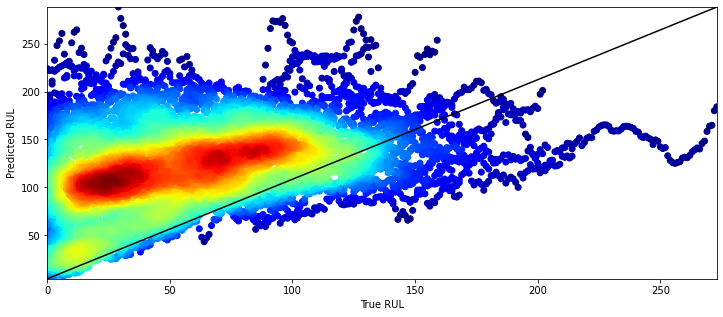

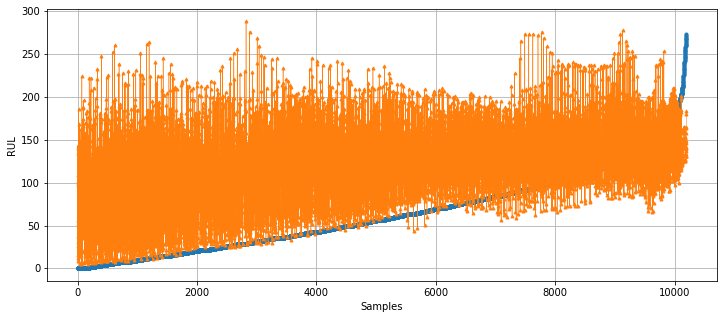

inicializacion de parametros
realizar data splitting
train split: 11347 samples

validation split: 2837 samples
realizar rutina de entrenamiento
Epoch 1/100
89/89 [==============================] - 5s 51ms/step - loss: 3452.7698 - mae: 41.9455 - val_loss: 1582.2032 - val_mae: 29.0376
Epoch 2/100
89/89 [==============================] - 4s 46ms/step - loss: 1539.2539 - mae: 28.2077 - val_loss: 1417.2847 - val_mae: 26.2200
Epoch 3/100
89/89 [==============================] - 4s 46ms/step - loss: 1403.6011 - mae: 26.4317 - val_loss: 1371.9276 - val_mae: 26.7146
Epoch 4/100
89/89 [==============================] - 4s 46ms/step - loss: 1253.8722 - mae: 24.7208 - val_loss: 1259.9326 - val_mae: 24.4059
Epoch 5/100
89/89 [==============================] - 4s 46ms/step - loss: 1231.1583 - mae: 24.2890 - val_loss: 1110.9392 - val_mae: 22.1683
Epoch 6/100
89/89 [==============================] - 4s 46ms/step - loss: 1097.4323 - mae: 22.9083 - val_loss: 1025.5769 - val_mae: 21.4760
Epoch 7/100
89/

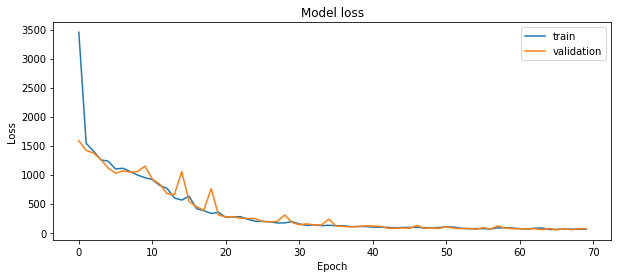

test2 rmse: 8.439


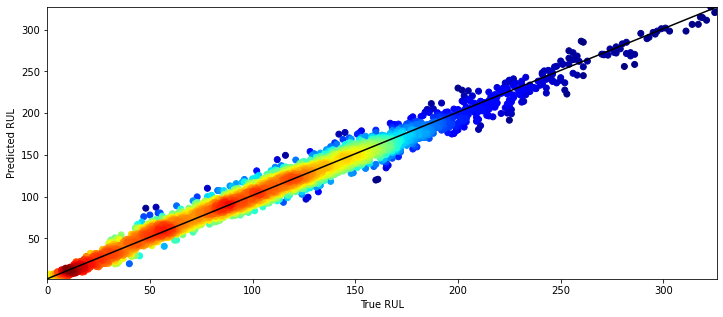

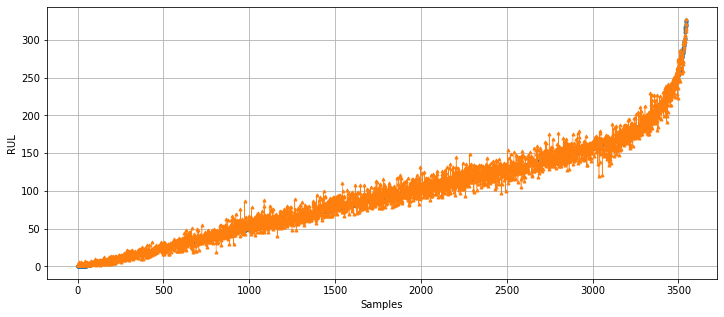

testing rmse: 74.972


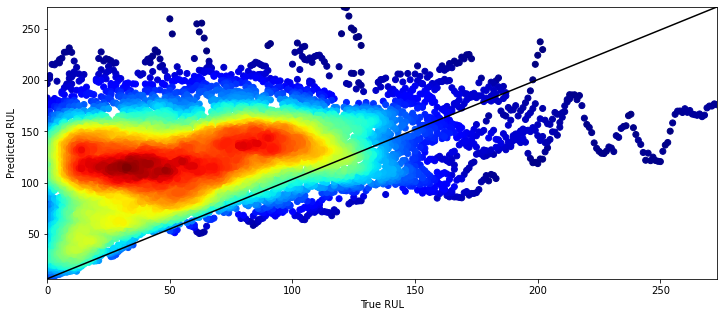

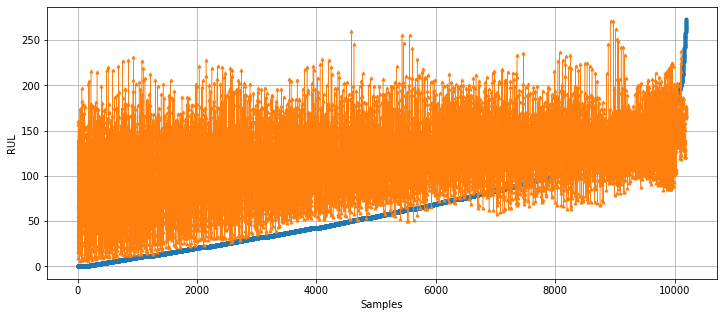

inicializacion de parametros
realizar data splitting
train split: 11347 samples

validation split: 2837 samples
realizar rutina de entrenamiento
Epoch 1/100
89/89 [==============================] - 5s 52ms/step - loss: 3012.1741 - mae: 40.5372 - val_loss: 1685.0830 - val_mae: 28.7326
Epoch 2/100
89/89 [==============================] - 4s 47ms/step - loss: 1577.1752 - mae: 28.7173 - val_loss: 1481.3151 - val_mae: 28.0566
Epoch 3/100
89/89 [==============================] - 4s 47ms/step - loss: 1430.6538 - mae: 26.8423 - val_loss: 1329.2054 - val_mae: 25.2829
Epoch 4/100
89/89 [==============================] - 4s 46ms/step - loss: 1358.6876 - mae: 25.7817 - val_loss: 1259.8754 - val_mae: 24.9282
Epoch 5/100
89/89 [==============================] - 4s 47ms/step - loss: 1239.5962 - mae: 24.6922 - val_loss: 1200.6820 - val_mae: 23.8791
Epoch 6/100
89/89 [==============================] - 4s 47ms/step - loss: 1139.3517 - mae: 23.6319 - val_loss: 1074.6433 - val_mae: 22.0035
Epoch 7/100
89/

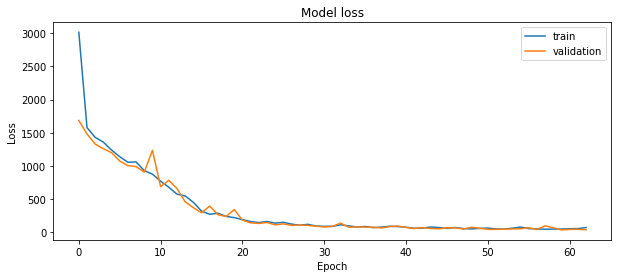

test2 rmse: 6.192


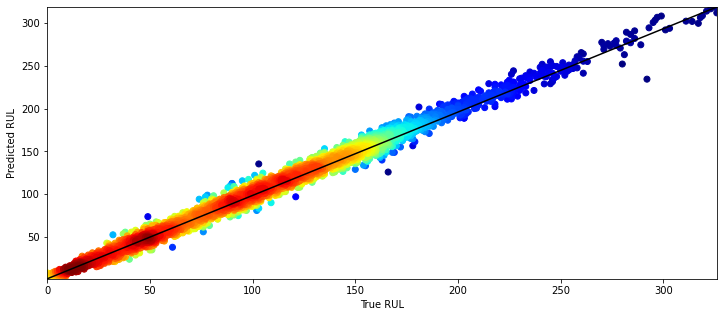

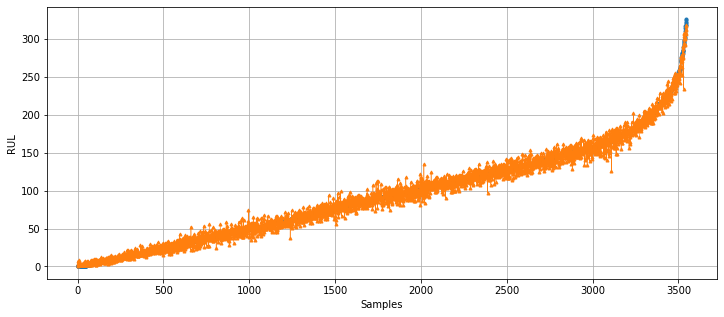

testing rmse: 73.307


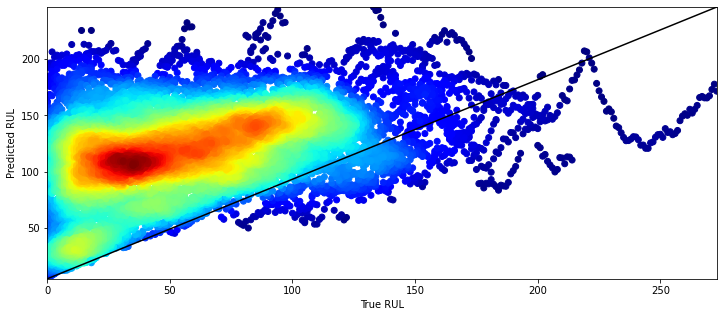

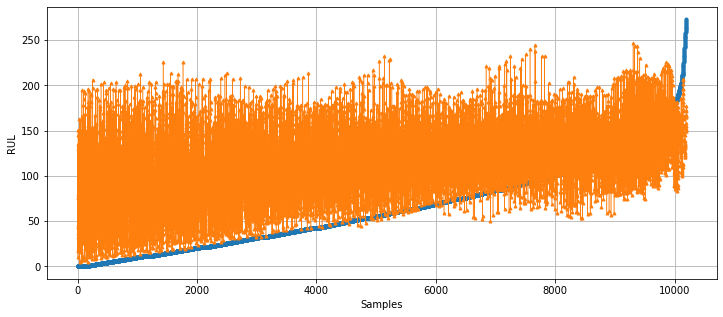

In [17]:
runRNN()
runRNN()
runRNN()

In [19]:
# LSTM
def runLSTM():
    model = Sequential()
    input_dim = ( 30, n_features )
    model.add( Input( shape=input_dim ) )

    model.add( LSTM(64, activation='relu', return_sequences=True ) )
    model.add( LSTM(64, activation='relu', return_sequences=True ) )
    model.add( Dropout(rate=0.1) )
    model.add( LSTM(32, activation='relu', return_sequences=True ) )
    model.add( LSTM(32, activation='relu', return_sequences=True ) )

    model.add( Flatten() )
    model.add( Dropout(rate=0.2) )
    model.add( Dense(units=96, activation='relu') )
    model.add( Dense(units=96, activation='relu') )
    model.add( Dense(units=64, activation='relu') )
    model.add( Dense(units=64, activation='relu') )
    model.add( Dense(units=1, activation='linear') )

    train(model, X_train, Y_train, X_test, Y_test, X_test2, Y_test2, 100)

In [ ]:
runLSTM()
runLSTM()
runLSTM()


inicializacion de parametros
realizar data splitting
train split: 11347 samples

validation split: 2837 samples
realizar rutina de entrenamiento
Epoch 1/100
89/89 [==============================] - 11s 124ms/step - loss: 4050.5391 - mae: 45.4533 - val_loss: 1744.4885 - val_mae: 29.5395
Epoch 2/100
89/89 [==============================] - 11s 118ms/step - loss: 1672.7859 - mae: 29.7129 - val_loss: 1641.8253 - val_mae: 29.9547
Epoch 3/100
89/89 [==============================] - 11s 118ms/step - loss: 1542.1901 - mae: 28.0472 - val_loss: 1475.2214 - val_mae: 27.5543
Epoch 4/100
89/89 [==============================] - 11s 120ms/step - loss: 1486.9700 - mae: 27.1809 - val_loss: 1409.9038 - val_mae: 25.5018
Epoch 5/100
89/89 [==============================] - 11s 118ms/step - loss: 1319.9198 - mae: 25.4608 - val_loss: 1195.1265 - val_mae: 24.0511
Epoch 6/100
25/89 [=======>......................] - ETA: 6s - loss: 1328.8070 - mae: 25.5588

## 2. Recurrent Models FD004

Utilizando la mejor arquitectura desarrollada en la sección anterior (sin cambiar sus hiperparámetros), entrenen el modelo sobre el dataset `FD004`. Luego, reporten:
- Utilizando las funciones `plot_RUL_scatter` y `plot_RUL_sorted` disponibles en el módulo `utils` del github del curso, grafiquen el desempeño del modelo sobre los conjuntos de testing de los datasets `FD001` y `FD004`.
- RMSE sobre el conjunto de testing de cada dataset para tres (3) iteraciones de entrenamiento, junto con sus promedios.

Comparen los resultados obtenidos sobre el dataset `FD004` con los observados en `FD001`, discutan sobre las diferencias a nivel de desempeño.

In [ ]:
# cargar archivo npz
dataset = np.load('/content/datasets/CMAPSS_FD004_raw.npz', allow_pickle=True)

In [ ]:
X_train, Y_train, X_test, Y_test = processData(dataset)

n_features = X_train.shape[2]


train split: 11347 samples

validation split: 3547 samples
Epoch 1/100
89/89 [==============================] - 5s 53ms/step - loss: 2633.6453 - mae: 37.6531 - val_loss: 1820.4025 - val_mae: 29.6815
Epoch 2/100
89/89 [==============================] - 4s 48ms/step - loss: 1606.7845 - mae: 29.1362 - val_loss: 1443.5822 - val_mae: 27.1373
Epoch 3/100
89/89 [==============================] - 4s 48ms/step - loss: 1410.6670 - mae: 26.7522 - val_loss: 1519.3295 - val_mae: 29.6702
Epoch 4/100
89/89 [==============================] - 4s 48ms/step - loss: 1319.0702 - mae: 25.6548 - val_loss: 1256.9934 - val_mae: 24.9895
Epoch 5/100
89/89 [==============================] - 4s 48ms/step - loss: 1315.1406 - mae: 25.5506 - val_loss: 1115.2878 - val_mae: 23.0576
Epoch 6/100
89/89 [==============================] - 4s 48ms/step - loss: 1134.2905 - mae: 23.7080 - val_loss: 1151.7422 - val_mae: 24.9436
Epoch 7/100
89/89 [==============================] - 5s 52ms/step - loss: 1093.3574 - mae: 23.0608 - 

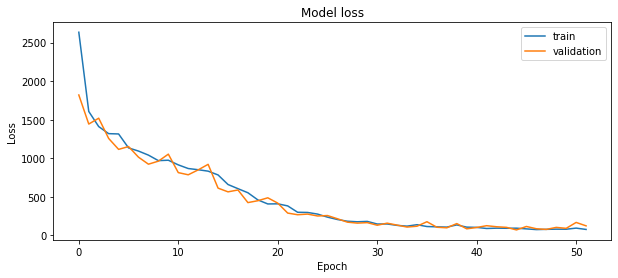

validation rmse: 11.057


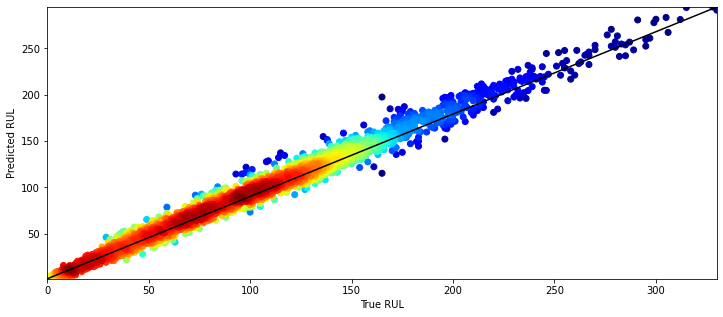

testing rmse: 66.771


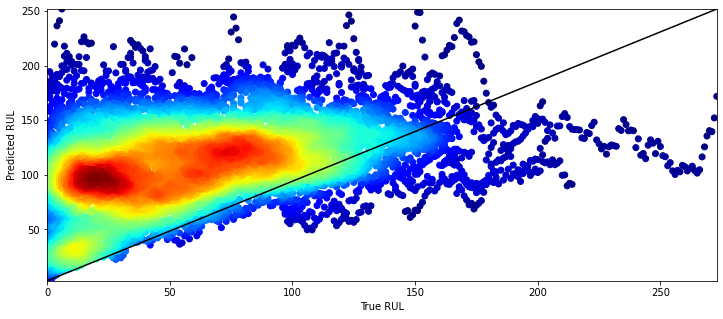

In [72]:
# RNN

# inicializar modelo keras.Sequential
model = Sequential()

input_dim = ( 30, n_features )
model.add( Input( shape=input_dim ) )

model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( Dropout(rate=0.1) )
model.add( RNN(32, activation='relu', return_sequences=True ) )
model.add( RNN(32, activation='relu', return_sequences=True ) )

model.add( Flatten() )
model.add( Dropout(rate=0.2) )
model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=1, activation='linear') )

train(model, X_train, Y_train, X_test, Y_test, 100)

## 3. Convolutional and Recurrent Model
Utilizando la mejor arquitectura desarrolla en la primera sección y el dataset `FD001`, incorporen en la red una etapa de preprocesamiento convolucional que alimentará a la etapa recurrente de su modelo. En particular, noten que las ventanas temporales al ser de la forma `(n_timesteps, n_features)` pueden ser interpretadas como imágenes de un solo canal. De este modo, consideren:
- Utilicen `np.reshape` para reestructurar los conjuntos `X_train` y `X_test` de modo que sean compatibles con la estructura `Conv2D` de `keras`.
- Para conectar los `feature maps` resultantes de la etapa convolucional con la etapa recurrente deben utilizar la capa `TimeDistributed( Flatten() )` de `keras`. Pueden encontrar información sobre esta estructura en la documentación.

La idea es que con este preprocesamiento mejoren las métricas sobre el conjunto de evaluación. Una vez entrenado su modelo de predicción, reporten:
- Arquitectura Conv2D-RNN/LSTM utilizada.
- RMSE sobre el conjunto de testing para tres (3) iteraciones de entrenamiento, junto con su promedio.

In [68]:
# reshape los datos de entrada
X_train_ = X_train.reshape(-1, 30, n_features, 1)
X_test_ = X_test.reshape(-1, 30, n_features, 1)
print(X_train_.shape, X_test_.shape)

(17731, 30, 15, 1) (10196, 30, 15, 1)


train split: 11347 samples

validation split: 3547 samples
Epoch 1/100
89/89 [==============================] - 14s 156ms/step - loss: 3364.3289 - mae: 42.2990 - val_loss: 1615.0886 - val_mae: 28.9082
Epoch 2/100
89/89 [==============================] - 13s 151ms/step - loss: 1653.1575 - mae: 29.5065 - val_loss: 1576.4387 - val_mae: 29.5883
Epoch 3/100
89/89 [==============================] - 13s 151ms/step - loss: 1509.8400 - mae: 27.6464 - val_loss: 1399.5822 - val_mae: 25.2548
Epoch 4/100
89/89 [==============================] - 13s 151ms/step - loss: 1421.1200 - mae: 26.6386 - val_loss: 1356.6987 - val_mae: 24.9002
Epoch 5/100
89/89 [==============================] - 13s 152ms/step - loss: 1345.8226 - mae: 25.6628 - val_loss: 1247.0909 - val_mae: 24.9338
Epoch 6/100
89/89 [==============================] - 13s 151ms/step - loss: 1282.6343 - mae: 24.9149 - val_loss: 1172.9291 - val_mae: 22.7700
Epoch 7/100
89/89 [==============================] - 16s 175ms/step - loss: 1211.5707 - m

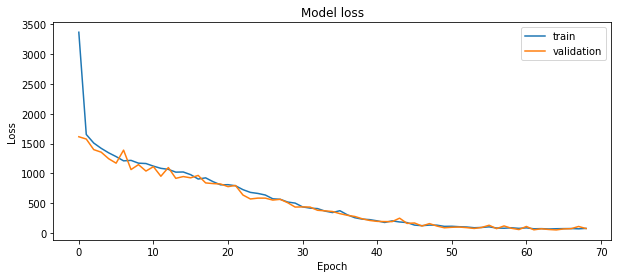

validation rmse: 9.262


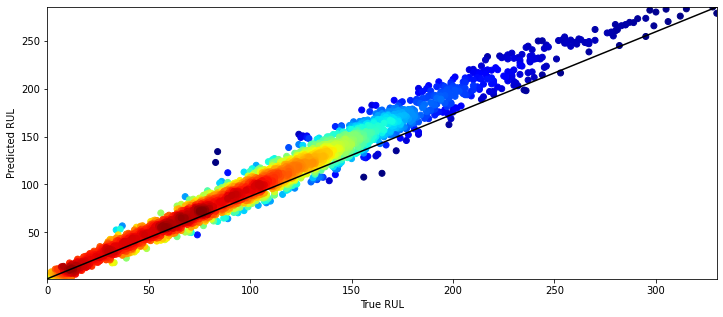

testing rmse: 68.707


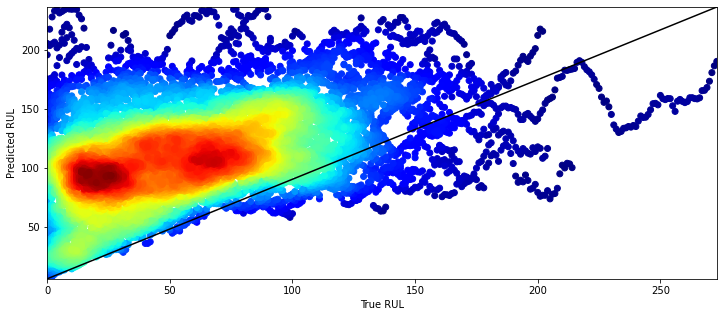

In [70]:
# creacion de red convolucional

# inicializar modelo keras.Sequential
model = Sequential()

input_dim = ( 30, n_features , 1)
model.add( Input( shape=input_dim ) )

model.add( layers.Conv2D(32,3, activation='relu') )
model.add( layers.Conv2D(32,3, activation='relu') )
model.add( layers.TimeDistributed( Flatten() ))
model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( Dropout(rate=0.1) )
model.add( RNN(32, activation='relu', return_sequences=True ) )
model.add( RNN(32, activation='relu', return_sequences=True ) )

model.add( Flatten() )
model.add( Dropout(rate=0.2) )
model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=1, activation='linear') )

train(model, X_train_, Y_train, X_test_, Y_test, 100)